# I. Introduction

## A. Objective
The main objective of this analysis is to evaluate the performance of linear regression models in predicting the mortality rate based on various features and to understand the importance of each feature in the model.
This research is a part of a series of trials of different ML models.

## B. Dataset Description
The dataset consists of the following features:
1. Age
1. HBR (b)
1. Systolic AP(b)
1. Creatine in blood
1. EF Percentage
1. White blood cells count
1. Glucose
1. CHF KiLLip_0.0
1. CHF KiLLip_1.0
1. CHF KiLLip_2.0
1. CHF KiLLip_3.0
1. CHF KiLLip_4.0

# II. Import Necessary Libraries

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from typing import List, Tuple

# III. Load Data

In [37]:
# Load dataset
ready_data = pd.read_csv('./import/dataset_prepared_KiLLip_encoded.csv')

# IV. Splitting and processing the Data

## A. Splitting

In [38]:
X_global = ready_data.drop('Class', axis=1)
y_global = ready_data['Class']

Initial split to hold out a test set

In [39]:
X_global_train, X_global_test, y_global_train, y_global_test = train_test_split(X_global, y_global, test_size=0.2, random_state=0, stratify=y_global)

## B. Standardize the data
To facilitate the interpretation of coefficients and the influence of features on the target variable we use the standard scaler.

In [40]:
scaler = StandardScaler()
X_global_train_scaled = scaler.fit_transform(X_global_train)
X_global_test_scaled = scaler.transform(X_global_test)

Convert scaled NumPy arrays back to Pandas DataFrames

In [41]:
X_global_train_scaled = pd.DataFrame(X_global_train_scaled, columns=X_global_train.columns)
X_global_test_scaled = pd.DataFrame(X_global_test_scaled, columns=X_global_test.columns)

We want to have more control over hyper parameters, so we examine three different random_state values. 

In [42]:
random_states = [0, 25, 42]

# V. Linear Regression Model

## A. Single Variable Regression

In [43]:
def evaluate_feature(
    X_train: pd.DataFrame, 
    y_train: pd.Series, 
    X_test: pd.DataFrame, 
    y_test: pd.Series, 
    feature: str, 
    skf: StratifiedKFold
) -> Tuple[float, float]:
    """
    Evaluate the importance and coefficient of a single feature using univariate Linear Regression.

    Parameters:
    X_train (pd.DataFrame): The feature matrix for training.
    y_train (pd.Series): The target variable for training.
    X_test (pd.DataFrame): The feature matrix for testing.
    y_test (pd.Series): The target variable for testing.
    feature (str): The name of the feature to evaluate.
    skf (StratifiedKFold): The cross-validation splitting strategy.

    Returns:
    Tuple[float, float]: A tuple containing the mean R-squared score and the coefficient of the feature.
    """
    model = LinearRegression()
    X_train_feature = X_train.loc[:, [feature]]
    X_test_feature = X_test.loc[:, [feature]]

    model.fit(X_train_feature, y_train)
    coefficient = model.coef_[0]

    scores = cross_val_score(model, X_test_feature, y_test, scoring="r2", cv=skf, n_jobs=-1)
    importance = np.mean(scores)
    
    return importance, coefficient

In [44]:
def evaluate_random_states(X: pd.DataFrame, y: pd.Series, random_states: List[int]) -> Tuple[int, float]:
    """
    Evaluate models with different random states and returns the random state of the best model based on mean R2 score.

    Parameters:
    X (pd.DataFrame): The feature matrix.
    y (pd.Series): The target variable.
    random_states (List[int]): A list of random states to evaluate.

    Returns:
    Tuple[int, float]: A tuple containing best random state and best mean R2 score.
    """
    best_r2 = -np.inf
    best_state = None

    for state in random_states:
        # Split the data using Stratified K-Fold
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=state)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=state, stratify=y)
        r2_scores = [evaluate_feature(X_train, y_train, X_test, y_test, feature, skf=skf)[0] for feature in X.columns]
        # Update best random state if current mean R2 is better
        current_r2 = np.mean(r2_scores)
        print(f"Random state={state}; r2={current_r2:.6f}")
        if current_r2 > best_r2:
            best_r2 = current_r2
            best_state = state

    return best_state, best_r2


### 1. Analyzing Random State Effect
Evaluating the effect of different random states on the model performance to understand the stability of the model.

In [45]:
# Find the best random state from the initial training set
best_state, best_r2 = evaluate_random_states(X_global_train_scaled, y_global_train, random_states=random_states)
print(f"Best: \n\trandom state:={best_state}; r2={best_r2:.6f}")

Random state=0; r2=0.001980
Random state=25; r2=0.021087
Random state=42; r2=0.013121
Best: 
	random state:=25; r2=0.021087


In [55]:
def compute_feature_importance_and_coefficients(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, skf: StratifiedKFold) -> pd.DataFrame:
    """
    Compute feature importances and coefficients for the provided training and testing data.
    """
    importances, coefficients = zip(*[evaluate_feature(X_train, y_train, X_test, y_test, feature, skf=skf) for feature in X_train.columns])  # Univariate linear regression for each feature
    feature_importances = pd.DataFrame(index=X_train.columns)
    feature_importances['Mean Coef'] = coefficients
    feature_importances['Mean Importance'] = importances
    

    return feature_importances

Compute feature importances and coefficients using the best model and evaluate on a hold out global test set.

In [56]:
feature_names = ["Age", "HBR (b)", "Systolic AP(b)", "Creatinine in blood", "EF Percentage", 
                 "White blood cells count", "Glucose", "CHF KiLLip_0.0", "CHF KiLLip_1.0", 
                 "CHF KiLLip_2.0", "CHF KiLLip_3.0", "CHF KiLLip_4.0"]
feature_importances = pd.DataFrame(index=feature_names)

best_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=best_state) 
feature_importances = compute_feature_importance_and_coefficients(X_global_train_scaled, y_global_train, X_global_test_scaled, y_global_test, best_skf)


### 2. Feature Importance Analysis

In [57]:
feature_importances # Calculated on a global train set

,Mean Coef,Mean Importance
Age,0.018350,0.013681
HBR (b),0.035178,0.045435
Systolic AP(b),-0.024459,-0.003003
Creatinine in blood,0.036875,0.020368
EF Percentage,-0.043467,0.018583
White blood cells count,0.026446,0.048313
Glucose,0.040413,0.004091
CHF KiLLip_0.0,-0.001396,-0.000260
CHF KiLLip_1.0,-0.026414,0.014469
CHF KiLLip_2.0,0.003548,-0.001734


### 3. Plotting features' weights and coefficients

In [53]:
def plot_weights (feature_importances, column1, column2, label1, label2, title, num_digits=3):
    plt.style.use('seaborn-v0_8-talk')  # Applying the style
    palette = sns.color_palette("husl", 2)  # Defining the color palette
    
    barWidth = 0.45

    r1 = np.arange(len(feature_importances[column1]))
    r2 = [x + barWidth for x in r1]

    plt.figure(figsize=(13, 6))
    bars1 = plt.barh(r1, feature_importances[column1], color=palette[0], height=barWidth, edgecolor='grey', label=label1)
    bars2 = plt.barh(r2, feature_importances[column2], color=palette[1], height=barWidth, edgecolor='grey', label=label2)
   
    plt.yticks([r + barWidth for r in range(len(feature_importances[column1]))], feature_importances.index, fontsize=10)

    def add_values(bars):
        for bar in bars:
            width = bar.get_width()
            if width >= 0:
                h_align = 'left'  # Horizontal alignment
                padding = 0.001  # Adjust this value to position the text to the right of the bar
            else:
                h_align = 'right' 
                padding = -0.000001  # Adjust this value to position the text to the left of the bar
        
            # The text will be positioned at the end of the bar (if positive) or at the start of the bar (if negative)
            plt.text(width + padding,               
                    bar.get_y() + bar.get_height() / 2.5 ,  
                    f"{width :.{num_digits}f}",  
                    ha=h_align, va='center', fontsize=7)

    add_values(bars1)
    add_values(bars2)

    plt.xlabel('Score', fontsize=12, fontweight='bold')
    plt.ylabel('Feature', fontsize=12, fontweight='bold')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

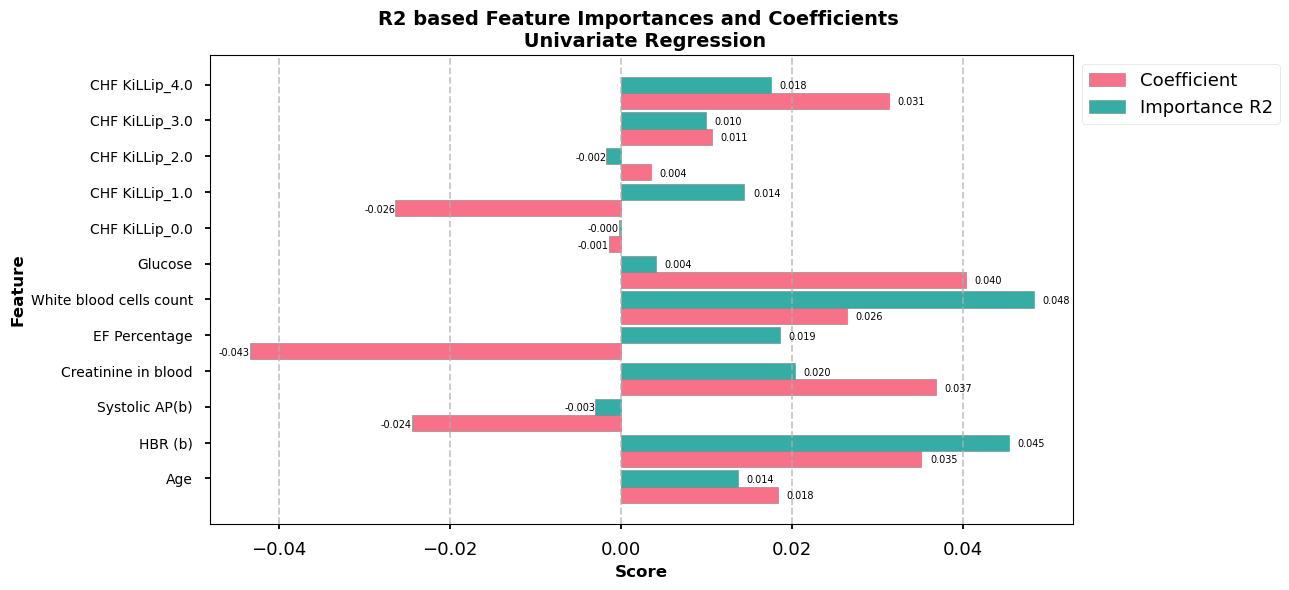

In [58]:
plot_weights(feature_importances, 
            'Mean Coef',
            'Mean Importance', 
            label1='Coefficient', 
            label2='Importance R2', 
            title='R2 based Feature Importances and Coefficients \n Univariate Regression' )

## B. Multivariate linear regression
### 1. Analyzing Random State Effect and choosing the best model

In [64]:
# Dictionary to hold the r2 score and model for each random state
r2_scores = {}
models = {}

for state in random_states:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=state)
    X_train, X_test, y_train, y_test = train_test_split(X_global_train_scaled, y_global_train, test_size=0.2, random_state=state, stratify=y_global_train)
    
    model = LinearRegression(n_jobs=-1)
    model.fit(X_train, y_train)

    scores = cross_val_score(model, X_test, y_test, scoring="r2", cv=skf)
    print(f"Mean cross-validation score: {np.mean(scores): .4f} for {state=}")

    # Save the model and r2 score
    r2_scores[state] = np.mean(scores)
    models[state] = model

# Find the random state with the highest r2 score
best_random_state = max(r2_scores, key=r2_scores.get)
best_model = models[best_random_state]

additional_test_score = best_model.score(X_global_test_scaled, y_global_test)
print(f"The best random state is {best_random_state} with an r2 score of {r2_scores[best_random_state]: .4f} on the validation set and {additional_test_score: .4f} on the additional test set.")


Mean cross-validation score: -0.0136 for state=0
Mean cross-validation score:  0.1064 for state=25
Mean cross-validation score:  0.0547 for state=42
The best random state is 25 with an r2 score of  0.1064 on the validation set and  0.1211 on the additional test set.


### 2. Feature Importance Analysis

In [60]:
import shap

feature_importances_multi = pd.DataFrame(index=feature_names)

explainer = shap.Explainer(best_model, X_global_train)
shap_values = explainer(X_global_test)

feature_importances_multi["Coef"] = model.coef_
feature_importances_multi["Mean shap values"] = np.mean(np.abs(shap_values.values), axis=0)


In [61]:
feature_importances_multi

,Coef,Mean shap values
Age,0.004784,0.045171
HBR (b),0.019291,0.244797
Systolic AP(b),-0.010007,0.157122
Creatinine in blood,0.025013,0.772926
EF Percentage,-0.034202,0.207627
White blood cells count,0.005494,0.016647
Glucose,0.034919,0.041552
CHF KiLLip_0.0,-0.001666,0.000008
CHF KiLLip_1.0,-0.005364,0.002619
CHF KiLLip_2.0,-0.004361,0.000337


### 3. Plotting features' SHAP values and coefficients

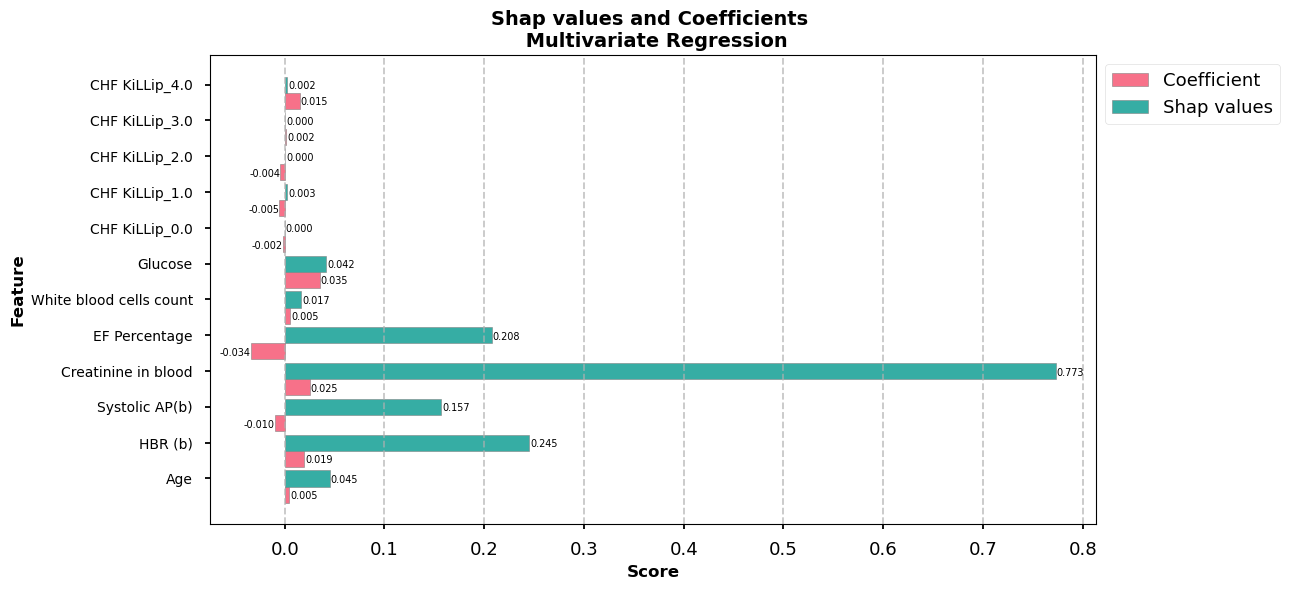

In [62]:
plot_weights(feature_importances_multi, 
             'Coef',
             'Mean shap values', 
             label1='Coefficient', 
             label2='Shap values', 
             title='Shap values and Coefficients \n Multivariate Regression', 
             num_digits = 3 )

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


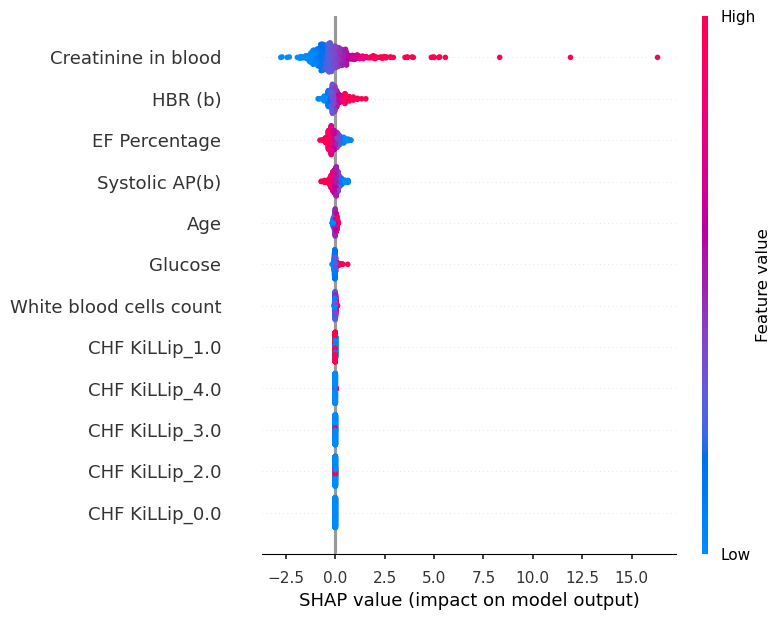

In [63]:
shap.summary_plot(shap_values.values, X_global_test, feature_names=feature_names, show=False)
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)

# VI. Conclusions and results
1. Сравнение весов признаков 
Comparison of feature weights.

    В одномерной регрессии мы оцениваем влияние отдельных признаков на зависимую переменную. К примеру, коэффициент у независимой переменной "возраст" 0.019805 говорит о положительном влиянии. 
    При этом в многомерной регрессии коэффициент признака учитывает влияние и других признаков на зависимую переменную. У переменной "возраст" коэффициент уменьшился в 45 раз до 0.000438, что говорит о том, что возраст менее важен, когда учитываются и другие признаки.
    Большинство признаков попадает под этот принцип.
    
    In univariate regression, we evaluate the impact of individual features on the dependent variable. For instance, the coefficient of the independent variable "age" is 0.019805, indicating a positive influence.
    In multivariate regression, the feature coefficient takes into account the influence of other features on the dependent variable. The coefficient of the variable "age" decreased 45 times to 0.000438, indicating that age is less significant when other features are taken into account.
    Most of the features fall under this principle.

1. Сравнение подлходов к оценке важности (R2 и SHAP values).
Comparison of approaches to assessing importance (R2 and SHAP values).

    Применяемые метрики говорят о разных аспектах важности независимых переменных в объяснении моделей. В частности более высокое значение R2 у переменной Systolic AP(b) (0.032077) говорит о том, что эта переменная сильнее всех связана с зависимой. При этом в многомерной регрессии высокое значение SHAP у переменной EF Percentage (0.023095) говорит о юолее сильном влиянии на предсказание модели с учётом взаимодействия с другими переменными.
    Существенная и заметная разница в важности свободной переменной между моделями (в частности изменение значения важности переменной Glucose со значением R^2 равным -0.065171 в одномерной в положительное SHAP значение, равное 0.013020) наглядно говорит о том, как критично может измениться важность параметра если учтено влияние других признаков.
    
    The applied metrics show different aspects of the importance of independent variables in explaining the models. In particular, a higher R2 value for the variable Systolic AP(b) (0.032077) indicates that this variable is the most associated with the dependent one. In multivariate regression, a high SHAP value for the variable EF Percentage (0.023095) indicates a stronger influence on the model prediction while taking interaction with other variables into account.
    A significant and noticeable difference in the importance of the independent variable between models (specifically, the change in the importance value of the variable Glucose from an R2 value of -0.065171 in univariate to a positive SHAP value of 0.013020) clearly indicates how critically the importance of a parameter can change if the influence of other features is taken into account.

1. Выводы.
Conclusions.

    Конечно же линейные модели и в частности одномерная регрессия далеко не лучшие подходы для бинарной классификации, впрочем их применение на самом раннем этапе побуждено желанием показать как "более понятное" может оказаться врагом "юолее точного". Разница в значениях важности признаков между одномерной и многомерной моделями указывает на важность понимания связей между независимыми переменными. А использование только упрощённых и легко объяснимых моделей может вести в заблуждение, так как не учитывает сложных скрытых взаимосвязей между свободными переменными. А также применение более целостного и сложного подхода (в частности SHAP Values) для оценки важности переменных позволяет лучше понять как эти переменные влияют на предсказание модели. 

    Of course, linear models and particularly univariate regression are far from the best approaches for binary classification, however, their use at the very early stage is motivated by the desire to show how "more understandable" can become the enemy of "more accurate". The difference in features' importance between univariate and multivariate models indicates the value of understanding the relationships between independent variables. And the use of only simplified and easily explainable models can lead to misconception, as it does not take into account the complex underlying interrelations between the independent variables. Also, the application of a more holistic and complex approach (in particular, SHAP Values) for assessing the importance of variables allows for a better understanding of how these variables affect the model prediction.